In [1]:
import sys
sys.path.insert(1, '/Users/madisonthantu/Desktop/DREAM/t-recs')
from trecs.metrics import Measurement, MSEMeasurement, InteractionSpread, InteractionSpread, InteractionSimilarity, RecSimilarity, RMSEMeasurement, InteractionMeasurement
from trecs.components import Users, Items

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
from collections import defaultdict

sys.path.insert(1, '/Users/madisonthantu/Desktop/DREAM/T-RECS-RS-research')
from wrapper.models.bubble import BubbleBurster
from wrapper.metrics.evaluation_metrics import TopicInteractionMeasurement, TopicInteractionSpread
from src.utils import compute_constrained_clusters, create_global_user_pairs, user_topic_mapping, create_cluster_user_pairs, load_and_process_movielens, compute_embeddings
from wrapper.metrics.clustering_metrics import MeanCosineSim, MeanDistanceFromCentroid, MeanCosineSimPerCluster, MeanDistanceFromCentroidPerCluster
from prelim_experiments.param_experiments.chaney_utils import *

import warnings
warnings.simplefilter("ignore")

import itertools

In [2]:
num_attributes=15
max_iter=1000
num_clusters = 10

data_path = '/Users/madisonthantu/Desktop/DREAM/data/ml-100k/u.data'
binary_ratings_matrix = load_and_process_movielens(file_path=data_path)
user_representation, item_representation = compute_embeddings(binary_ratings_matrix, n_attrs=num_attributes, max_iter=max_iter)

item_cluster_ids, item_cluster_centers = compute_constrained_clusters(embeddings=item_representation.T, name='item_clusters', n_clusters=num_clusters)
user_cluster_ids, user_cluster_centers = compute_constrained_clusters(embeddings=user_representation, name='user_clusters', n_clusters=num_clusters)
inter_cluster_user_pairs, intra_cluster_user_pairs = create_cluster_user_pairs(user_cluster_ids)
                
users = Users(
    actual_user_profiles=user_representation, 
    repeat_interactions=False,
    drift=0.05,
    attention_exp=-0.2
)

Calculating embeddings ...
... Calculated embeddings.
Calculating constrained clusters ...
... Calculated constrained clusters.
Calculating constrained clusters ...
... Calculated constrained clusters.


<BarContainer object of 1682 artists>

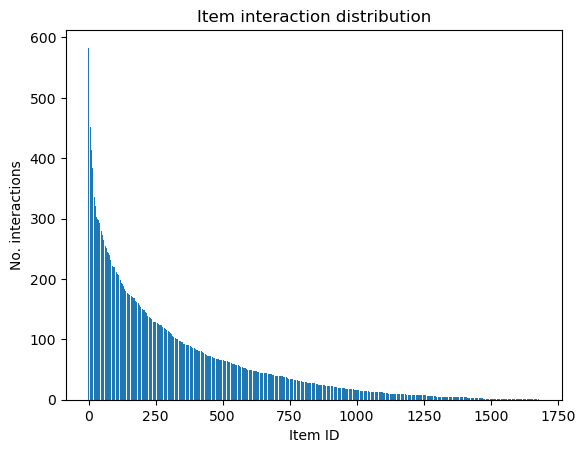

In [3]:
def plot_item_popularity_distribution(interaction_matrix, y_label="No. interactions", x_label="Item ID", title="Item interaction distribution", ax=None):
    intrxn_per_item = np.sort(np.sum(interaction_matrix, axis=0))[::-1]
    fig = plt.bar(np.arange(intrxn_per_item.size), intrxn_per_item)
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    return fig

plot_item_popularity_distribution(binary_ratings_matrix)

In [4]:
metrics_list = [
    MSEMeasurement(diagnostics=True),
    MeanCosineSim(pairs=intra_cluster_user_pairs, name='mean_intra_cluster_cosine_sim', diagnostics=True),
    InteractionSimilarity(pairs=intra_cluster_user_pairs, name="test_interaction_similarity", diagnostics=True),
    InteractionSpread(),
    InteractionMeasurement(),
    TopicInteractionMeasurement(),
    TopicInteractionSpread()
]

metric_to_y_label = {
    "mse":"mse",
    "mean_intra_cluster_cosine_sim":"average intra-cluster cosine sim",
    "interaction_spread":"item interaction diversity",
    "topic_interaction_spread":"topic interaction diversity",
}

graphing_metrics = [
    "mse",
    "mean_intra_cluster_cosine_sim",
    "interaction_spread",
    "topic_interaction_spread"
]

bubble = BubbleBurster(
    actual_user_representation=users, 
    actual_item_representation=item_representation,
    item_topics=item_cluster_ids,
    num_attributes=num_attributes,
    num_items_per_iter=10,
    record_base_state=True
)

In [5]:
train_timesteps = 10
run_timesteps = 50
repeated_training = 1

bubble.add_metrics(*metrics_list)
bubble.startup_and_train(timesteps=train_timesteps)
bubble.run(timesteps=run_timesteps, train_between_steps=repeated_training)
bubble.close() # end logging

100%|██████████| 50/50 [01:39<00:00,  1.99s/it]


In [6]:
measurements = bubble.get_measurements()
measurements.keys()

dict_keys(['mse', 'mean_intra_cluster_cosine_sim', 'test_interaction_similarity', 'interaction_spread', 'interaction_histogram', 'topic_interaction_histogram', 'topic_interaction_spread', 'timesteps'])

In [7]:
def graph_metrics_by_axis(ax, results, metric_key, metric_key_map):
    ax.plot(results[metric_key])#, label=metric_key)
    ax.set_title(f"{metric_key}")
    ax.set_ylabel(metric_key_map[metric_key])
    ax.set_xlabel("Timestep")
    return ax

Inheriting from BaseRecommender


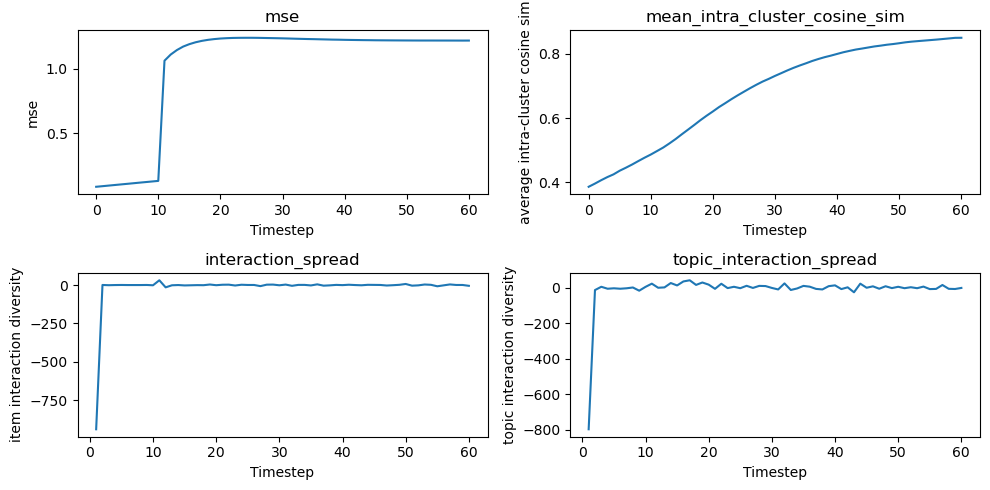

In [8]:
fig, axs = plt.subplots(2, 2, figsize=(10, 5))
for i in range(4):
    curr_ax = axs[int(i >= 2), i%2]
    graph_metrics_by_axis(curr_ax, measurements, graphing_metrics[i], metric_to_y_label)
plt.tight_layout()
print("Inheriting from BaseRecommender")

In [9]:
bubble.interactions

array([ 668,  950, 1218, 1499, 1500, 1296, 1218, 1378, 1136, 1138, 1218,
        309, 1407, 1045,  309, 1387,   39,  113,  618,  646, 1219, 1400,
       1442,  784, 1218,  845, 1027, 1129, 1485,   98,   22,  316, 1579,
       1537, 1210,  582, 1479,  279, 1218,  993, 1502, 1406, 1476,  539,
        619, 1050,  615,   36,  104,  762, 1571,  877, 1355, 1369, 1612,
        952, 1572, 1659,    6,   54,  349, 1275, 1146,  907, 1176,   69,
       1105,  863,  206,  618,  500, 1509,  276,  398,  643, 1177, 1229,
         54,  762,  321,  435,  389,  258, 1106, 1218, 1542,  158, 1140,
       1140, 1630,  271,  929,   99,  219,  380, 1481,  965,  146,   46,
       1535,  942,  888, 1140,  584,  371,  309, 1464,  968, 1678,  618,
       1045, 1529,  388,  643, 1147,   46, 1584,  741,   54,  642,  215,
       1424, 1579,  318, 1400,  688,    8,  710,  980, 1331, 1432, 1176,
       1582, 1283,  739,  500, 1076,  480,  583,   65, 1395, 1590, 1479,
       1218, 1071,  568,   80, 1491, 1116,  294,  9